#### Poisson

\begin{eqnarray}
{\bf \nabla} \left(\varepsilon ({\bf r}) {\bf \nabla} \phi ({\bf r}) \right) &=& -\rho({\bf r}) \\
\rho({\bf r}) &=& q \left(-N_A({\bf r}) - n_e({\bf r}) + N_D({\bf r}) + n_h({\bf r}) \right)
\end{eqnarray}

#### Conservation

\begin{eqnarray}
\frac{d}{dt} n_e({\bf r}) &=& {\bf \nabla} {\bf J}_e ({\bf r}) + G({\bf r}) - U({\bf r}) \\
\frac{d}{dt} n_h({\bf r}) &=& {\bf \nabla} {\bf J}_h ({\bf r}) + G({\bf r}) - U({\bf r})
\end{eqnarray}

#### Current

\begin{eqnarray}
{\bf J}_e &=& -\mu_e n_e {\bf \nabla} \phi - D_e {\bf \nabla} n_e \\
{\bf J}_h &=&  \mu_h n_h {\bf \nabla} \phi -  D_h {\bf \nabla} n_h \\
\mu_e &=& \frac{q D_e}{k_B T}
\end{eqnarray}

In [23]:
import os, sys, re, glob, numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simps
from collections import OrderedDict
#import ase
#from ase.data import kB
%matplotlib inline
kB = 8.6173303e-5 # eV / K
kB_inJ = 1.38064852e-23 # J / K
e = 1.602176462e-19 # Coulomb
epsilon_Si = 12.0
epsilon_0 = 8.854187817e-12 # F / m = C / V m,  F = C/V
q_eps0 = e/epsilon_0 # C (C/Vm)^-1 = V m

In [2]:
print(q_eps0)

1.8095126228560778e-08


In [3]:

def SOR(A, b, tol, debug=False, xOld=None):
    # 線形連立方程式を SOR 法で解く
    if xOld is None:
        xOld = np.empty_like(b)
    error = 1e12

    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = A - L - D

    Mj = np.dot(np.linalg.inv(D), -(L+U))
    rho_Mj = max(abs(np.linalg.eigvals(Mj)))
    if (1-rho_Mj**2)>0:
        w = 2/(1+np.sqrt(1-rho_Mj**2))
    else:
        w = 1.0 # Gauss-Seidel
    if debug:
        print('D : \n',D)
        print('L : \n',L)
        print('U : \n',U)
        print('Mj : ', Mj)
        print('rho_Mj :\n', rho_Mj)
        print(1-rho_Mj**2)
    T = np.linalg.inv(D+w*L)
    Lw = np.dot(T, -w*U+(1-w)*D)
    c = np.dot(T, w*b)

    while error > tol:
        x = np.dot(Lw, xOld) + c
        error = np.linalg.norm(x-xOld)/np.linalg.norm(x)
        xOld = x
    return x

A = np.array([[7, -1, 0, 1],
              [-1, 9, -2, 2],
              [0, -2, 8, -3],
              [1, 2, -3, 10]])
b = np.array([-5, 15, -10, 20])

x = SOR(A, b, 1e-9, True)
print(x)

#--> same result
fac = 5
x2 = SOR(A,b*fac,1e-9, debug=False)
print(x2/fac)

D : 
 [[ 7  0  0  0]
 [ 0  9  0  0]
 [ 0  0  8  0]
 [ 0  0  0 10]]
L : 
 [[ 0  0  0  0]
 [-1  0  0  0]
 [ 0 -2  0  0]
 [ 1  2 -3  0]]
U : 
 [[ 0 -1  0  1]
 [ 0  0 -2  2]
 [ 0  0  0 -3]
 [ 0  0  0  0]]
Mj :  [[ 0.          0.14285714  0.         -0.14285714]
 [ 0.11111111  0.          0.22222222 -0.22222222]
 [ 0.          0.25        0.          0.375     ]
 [-0.1        -0.2         0.3         0.        ]]
rho_Mj :
 0.5254032883446224
0.7239513845966576
[-0.80693816  1.11613876 -0.3092006   1.76470588]
[-0.80693816  1.11613876 -0.3092006   1.76470588]


In [4]:
cm=1e-2
nm=1e-9
print(cm**3, nm**3)

1.0000000000000002e-06 1.0000000000000002e-27


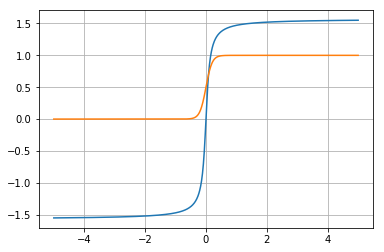

In [5]:
#--> test arctan and sigmoid for fixed charge distributions.
mesh = np.linspace(-5, 5, 1000)
fac=10
plt.plot(mesh, np.arctan(fac*(mesh-np.average(mesh))))
plt.plot(mesh, 1/(1+np.exp(fac*(-mesh-np.average(-mesh)))))
plt.grid()

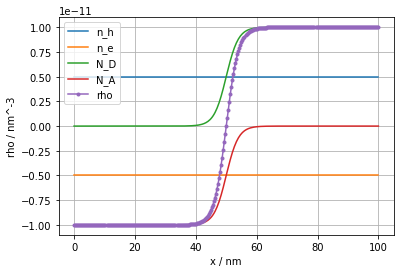

In [6]:
#--> set inputs
Lx = 100.0e-9  # sample width 100 nm
xlim = [0.0, Lx] # length [nm]
nmesh=301
center = int((nmesh-1)/2)
mesh = np.linspace(*xlim, nmesh)

N_A0 = 1e-17
N_A0 *= 1e6 # [cm-3 -> m-3]
N_D0 = 1e-17
N_D0 *= 1e6

T = 300.0  # K

epsilon = epsilon_Si * epsilon_0
q = e
qkt = q/(kB_inJ*T)

# D=mu kB T / q
mu_e = 0.15  #  m^2 / V s 
mu_h = 0.05  #  m^2 / V s
D_e = mu_e / qkt
D_h = mu_h / qkt

n_e = np.zeros_like(mesh)
n_h = np.zeros_like(mesh)
phi = np.zeros_like(mesh)
N_A = np.zeros_like(mesh)
N_D = np.zeros_like(mesh)

fac=5e8
N_A = N_A0 * 1/(1+np.exp(fac*(mesh-np.average(mesh)) ))
N_D = N_D0 * 1/(1+np.exp(fac*(-mesh-np.average(-mesh)) ))
n_h[:] = simps(N_A, mesh)/Lx
n_e[:] = simps(N_D, mesh)/Lx

G = np.zeros_like(mesh)
U = np.zeros_like(mesh)

def get_rho(n_h, n_e, N_D, N_A):
     return (n_h - n_e + N_D - N_A)
rho = get_rho(n_h, n_e, N_D, N_A)

n_h0 = n_h.copy()
n_e0 = n_e.copy()
phi0 = phi.copy()
rho0 = rho.copy()

_x = mesh * 1e9
plt.plot(_x, n_h, label='n_h')
plt.plot(_x, -n_e, label='n_e')
plt.plot(_x, N_D, label='N_D')
plt.plot(_x, -N_A, label='N_A')
plt.plot(_x, rho, '.-', label='rho')
ax = plt.gca()
ax.set_xlabel('x / nm')
ax.set_ylabel('rho / nm^-3')
ax.legend()
plt.grid()

1.0000000000000002 [0.97882791 0.97340224 0.95538298 0.97969105 1.0303478  1.0230208
 1.00332816 0.99398463 1.00106031 1.03233153]


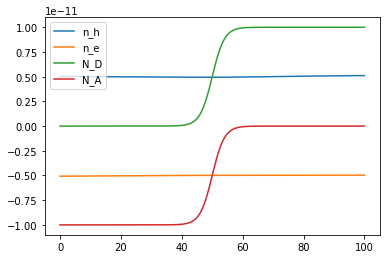

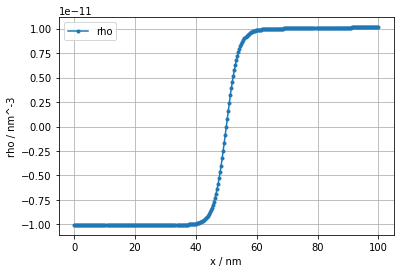

In [7]:
def tmp(a, n=10):
    tmp = a.copy()
    for i in range(n):
        tmp[i] = np.average(a[0:i+n])
        tmp[-(i+1)] = np.average(a[-i-1-n:])
    for i in range(n, len(a)-n):
        tmp[i] = np.average(a[i-n:i+n])
    return tmp

def get_random(nmesh, fac=0.1, nave=0.05):
    _random = tmp(np.random.random(nmesh), n=int(nmesh*nave))
    _random = tmp(_random, n=int(nmesh*nave))
    _random = 1.0 + (_random - np.average(_random))*fac
    return _random

_random = get_random(100, fac=1.0, nave=0.1)
print(np.average(_random), _random[::10])

#_random = (_random - np.average(_random))
#n_e0 = n_e0 + _random
#n_h0 = n_h0 - _random[::-1]
#n_e0 = n_e + _random 

_n_e0 = n_e0 * get_random(nmesh, fac=0.5, nave=0.2)
_n_h0 = n_h0 * get_random(nmesh, fac=0.5, nave=0.2)

_x = mesh * 1e9
plt.plot(_x, _n_h0, label='n_h')
plt.plot(_x, -_n_e0, label='n_e')
plt.plot(_x, N_D, label='N_D')
plt.plot(_x, -N_A, label='N_A')
plt.legend()
plt.show()

plt.plot(_x, get_rho(_n_h0, _n_e0, N_D, N_A), '.-', label='rho')
ax = plt.gca()
ax.set_xlabel('x / nm')
ax.set_ylabel('rho / nm^-3')
ax.legend()
plt.grid()

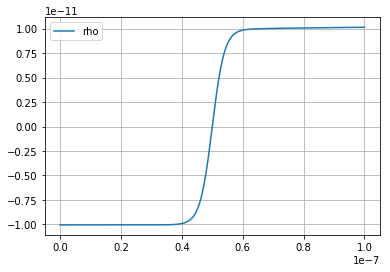

[[-1.   1.  -0.  ... -0.  -0.  -0. ]
 [ 0.5 -1.   0.5 ... -0.  -0.  -0. ]
 [-0.   0.5 -1.  ... -0.  -0.  -0. ]
 ...
 [-0.  -0.  -0.  ... -1.   0.5 -0. ]
 [-0.  -0.  -0.  ...  0.5 -1.   0.5]
 [-0.  -0.  -0.  ... -0.   1.  -1. ]]
D : 
 [[-1.  0.  0. ...  0.  0.  0.]
 [ 0. -1.  0. ...  0.  0.  0.]
 [ 0.  0. -1. ...  0.  0.  0.]
 ...
 [ 0.  0.  0. ... -1.  0.  0.]
 [ 0.  0.  0. ...  0. -1.  0.]
 [ 0.  0.  0. ...  0.  0. -1.]]
L : 
 [[ 0.   0.   0.  ...  0.   0.   0. ]
 [ 0.5  0.   0.  ...  0.   0.   0. ]
 [-0.   0.5  0.  ...  0.   0.   0. ]
 ...
 [-0.  -0.  -0.  ...  0.   0.   0. ]
 [-0.  -0.  -0.  ...  0.5  0.   0. ]
 [-0.  -0.  -0.  ... -0.   1.   0. ]]
U : 
 [[ 0.   1.  -0.  ... -0.  -0.  -0. ]
 [ 0.   0.   0.5 ... -0.  -0.  -0. ]
 [ 0.   0.   0.  ... -0.  -0.  -0. ]
 ...
 [ 0.   0.   0.  ...  0.   0.5 -0. ]
 [ 0.   0.   0.  ...  0.   0.   0.5]
 [ 0.   0.   0.  ...  0.   0.   0. ]]
Mj :  [[0.  1.  0.  ... 0.  0.  0. ]
 [0.5 0.  0.5 ... 0.  0.  0. ]
 [0.  0.5 0.  ... 0.  0.  0. ]
 ...
 [

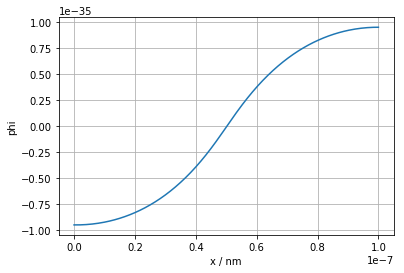

In [8]:

def SOR(A, b, tol, debug=False, xOld=None):
    # 線形連立方程式を SOR 法で解く

    if xOld is None:
        xOld = np.empty_like(b)

    D = np.diag(np.diag(A))
    L = np.tril(A, -1)
    U = A - L - D

    Mj = np.dot(np.linalg.inv(D), -(L+U))
    rho_Mj = max(abs(np.linalg.eigvals(Mj)))
    if (1-rho_Mj**2)>0:
        w = 2/(1+np.sqrt(1-rho_Mj**2))
    else:
        w = 1.0 # Gauss-Seidel
        
    if debug:
        print('D : \n',D)
        print('L : \n',L)
        print('U : \n',U)
        print('Mj : ', Mj)
        print('rho_Mj :\n', rho_Mj)
        print(1-rho_Mj**2)
    
    T = np.linalg.inv(D+w*L)
    Lw = np.dot(T, -w*U+(1-w)*D)
    c = np.dot(T, w*b)

    error = 1e120
    while error > tol:
        x = np.dot(Lw, xOld) + c
        error = np.linalg.norm(x-xOld)/np.linalg.norm(x)
        xOld = x
 
    return x

def get_phi(mesh, rho, epsilon, q, tol=1e-4, debug=False, scale_fac=None):
    dx = mesh[1]-mesh[0]
    n = len(mesh)

    A = np.eye(n)
    A *= -1

    #--> dphi/dx = 0 at the boundary.
    A[0, 1] = A[-1, -2] = 1

    for i in range(1, n-1):
        A[i, i+1] = A[i, i-1] = 1/2
        
    if debug:
        print(A)

    #--> set scale factor for tiny rho values below the numerical accuracy.
    if isinstance(scale_fac, (float, int)):
        _scale_fac = scale_fac
    elif scale_fac is True:
        _scale_fac = np.max(np.abs(rho))
    else:
        _scale_fac = 1.0
        
    _fac = -_scale_fac * 2/dx**2 * epsilon / q

    _rho = _scale_fac * rho #--> -dx**2/2*(q/epsilon)*rho * _fac
#    _rho = dx**2/2 *( -q / epsilon) * rho
#    _rho = _scale_fac * dx**2/2 * (-q/epsilon) * rho
    _rho[0] = _rho[-1] = 0.0
    
#    _rho[0] = _rho[-1] = 1e-16
    xOld = np.empty_like(_rho)
    xOld[0] = 0.0
    
    _phi = SOR(A, _rho, tol, debug=debug, xOld=xOld)

    phi = _phi / _fac

    return phi

#print(mesh)
#print(rho0)
#print(epsilon)

_rho = get_rho(_n_h0, _n_e0, N_D, N_A)
plt.plot(mesh, _rho, label='rho')
plt.grid()
plt.legend()
plt.show()

phi = get_phi(mesh, _rho, epsilon, q, debug=True, scale_fac=1e3)
print(phi)
plt.plot(mesh, phi)
ax=plt.gca()
ax.set_xlabel('x / nm')
ax.set_ylabel('phi')
plt.grid()

1.5115527447385114e-08


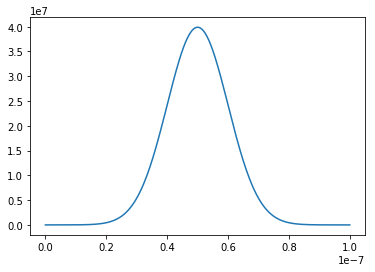

0.0 4.533333333333333e-08 6.366666666666667e-08 1e-07 301 1.6666666666666667e-09
charges : 
-0.9999999999999999 0.9999999999999999


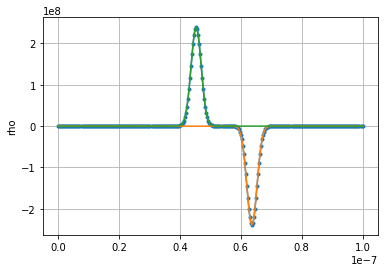

get phi in 0 trials
[-1.13816576e-34 -1.13828798e-34 -1.13833027e-34 -1.13829260e-34
 -1.13817492e-34] [1.14368869e-34 1.14393848e-34 1.14410503e-34 1.14418831e-34
 1.14418831e-34]
get phi in 0 trials
[-1.13816576e-34 -1.13828798e-34 -1.13833027e-34 -1.13829260e-34
 -1.13817492e-34] [1.14368869e-34 1.14393848e-34 1.14410503e-34 1.14418831e-34
 1.14418831e-34]
get phi in 0 trials
[-1.13809690e-34 -1.13821912e-34 -1.13826143e-34 -1.13822379e-34
 -1.13810613e-34] [1.14362212e-34 1.14387190e-34 1.14403843e-34 1.14412170e-34
 1.14412170e-34]
get phi in 0 trials
[-1.13816576e-34 -1.13828798e-34 -1.13833027e-34 -1.13829260e-34
 -1.13817492e-34] [1.14368869e-34 1.14393848e-34 1.14410503e-34 1.14418831e-34
 1.14418831e-34]
get phi in 0 trials
[-1.13817060e-34 -1.13829282e-34 -1.13833511e-34 -1.13829744e-34
 -1.13817975e-34] [1.14369368e-34 1.14394348e-34 1.14411003e-34 1.14419331e-34
 1.14419331e-34]


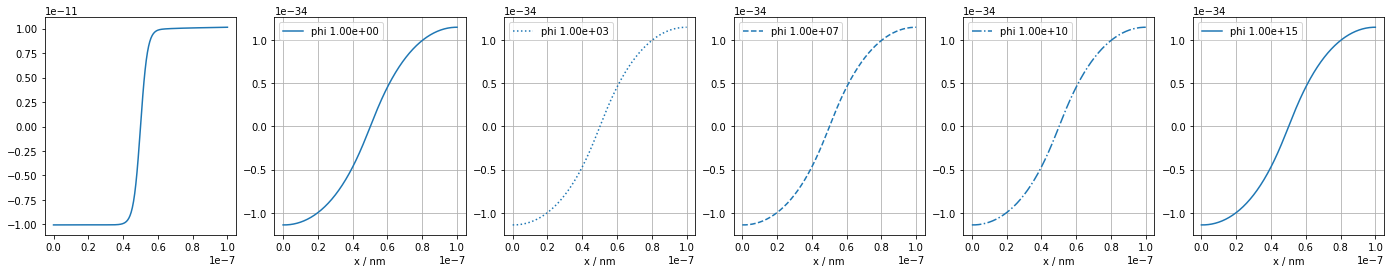

In [9]:
def gauss(x, x0, s):
    _g = np.zeros_like(x)
    for i, _x in enumerate(x):
        _g[i] = 1/np.sqrt(2*np.pi*s**2)*np.exp(-((_x-x0)/s)**2/2)
    return _g

from scipy.integrate import simps
print(simps(gauss(x, 0.5, 0.1), x))

plt.plot(mesh, gauss(mesh, 5e-8, 1e-8))
plt.show()

#mesh=x
_s = (mesh[1]-mesh[0])*5

_xp = mesh[int(len(mesh)*5/11)]
_rhop = gauss(mesh, _xp, _s)

_xm = mesh[int(len(mesh)*7/11)]
_rhom = -gauss(mesh, _xm, _s)

print(mesh[0], _xp, _xm, mesh[-1], len(mesh), _s)
print('charges : ', end=None)
print(simps(_rhom, mesh), simps(_rhop, mesh))

plt.plot(mesh, _rhom + _rhop, '.-')
plt.plot(mesh, _rhom)
plt.plot(mesh, _rhop)
plt.grid()
plt.gca().set_ylabel('rho')
#_rho = get_rho(n_h0, n_e0, N_D0, N_A0)

plt.show()

#--> get_phi frequently failed.
#--> test phi using scaling factor.

facs = [1.0, 1e3, 1e7, 1e10, 1e15] 
ls = ['-', ':', '--', '-.']
ls = ls + ls
huge = 1e100
ncols=len(facs)+1
fig, axes = plt.subplots(ncols=ncols, figsize=(4*ncols, 4))

#_rho_tmp = _rhom + _rhop
_rho_tmp = get_rho(_n_h0, _n_e0, N_D, N_A)
axes[0].plot(mesh, _rho_tmp, label='rho')

for i, (_ax, _fac) in enumerate(zip(axes[1:], facs)):
    _phi = get_phi(mesh, _rho_tmp, epsilon_0, q, debug=False, scale_fac=_fac)
    count, count_max = 0, 1000

    for count in range(0, count_max):
        if np.max(np.abs(_phi)) > huge:
            _phi = get_phi(mesh, _rho_tmp, epsilon_0, q, debug=False, scale_fac=_fac)
        else:
            print('get phi in {} trials'.format(count))
            break
    else:
        print('can not get phi in {} trials.'.format(count))
        _phi = get_phi(mesh, _rho_tmp, epsilon_0, q, debug=False, scale_fac=True)
        
    print(_phi[:5], _phi[-5:])
    _ax.plot(mesh, _phi, label='phi {:.2e}'.format(_fac), linestyle=ls[i])
    _ax.set_xlabel('x / nm')
    _ax.legend()
    _ax.grid()

plt.show()

/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in double_scalars


[1, 1e-10, 1e-20, 1e-30, 1e-40]
[0.5819767068693265, 0.9999999172596359, inf, inf, inf]


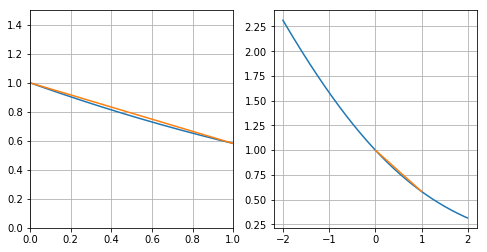

In [10]:
#--> lim x-> 0, x/(e^x -1)  should be 1 but it goes inf for small x by error.
x = np.arange(-2, 2, 0.01)
tmp = [_/(np.exp(_)-1) for _ in x]
x2 = [10**(-1*int(_)) for _ in np.arange(0, 50, 10)]
tmp2 = [_/(np.exp(_) -1 ) for _ in x2]

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
ax0, ax1 = axes
ax0.plot(x,tmp)
ax0.plot(x2,tmp2)
ax0.set_xlim(0,1)
ax0.set_ylim(0,1.5)
ax0.grid()
ax1.plot(x,tmp)
ax1.plot(x2,tmp2)
ax1.grid()
print(x2)
print(tmp2)

### Sharfetter-Gummel

\begin{eqnarray}
  \frac{d}{dx} J(x_i) &=& \frac{1}{dx} \left( J_{i+\frac{1}{2}} - J_{i-\frac{1}{2}} \right) \\
  &=& \frac{1}{dx}[ D \left( -B(-t_i) n_{i+1} + B(t_i) n_i  \right) + D \left(B(-t_{i-1}) n_i - B(t_{i-1}) n_{i-1} \right) ]\\ 
  &=& \frac{1}{dx} D \left( a_{i+1} n_{i+1} + a_i n_i + a_{i-1} n_{i-1} \right) 
\end{eqnarray}

where

\begin{eqnarray}
a_{i+1} &=& -B(-t_i)  \\
      a_i &=& B(t_i) + B(-t_{i-1})  \\
a_{i-1}  &=& -B(t_{i-1})  \\
B(t) &=& \frac{1}{e^t -1} \\
t_i &=& \beta \Delta \phi_i  \\
     &=& \left(\frac{q}{k_B T}\right)\left(\phi_{i+1} - \phi_i\right) \\
\end{eqnarray}

両端の境界条件どうする？　とりあえず下記を使う：


\begin{eqnarray}
  \frac{d}{dx} J(x_0) &=& \frac{1}{dx} J_{\frac{1}{2}} \\
  &=& \frac{1}{dx} D \left( -B(-t_0) n_{1} + B(t_0) n_0 \right) \\ 
  &=& \frac{1}{dx} D \left( a_{1} n_{1} + a_0 n_0 \right)  \\
  where \\
  a_{1} &=& -B(-t_0) \\
  a_{0} &=& B(t_0) \\
\end{eqnarray}


\begin{eqnarray}
  \frac{d}{dx} J(x_{n}) &=& \frac{1}{dx} \left(- J_{n-\frac{1}{2}} \right) \\
  &=& \frac{1}{dx} D \left( B(-t_{n-1}) n_n - B(t_{n-1}) n_{n-1} \right) \\ 
  &=& \frac{1}{dx} D \left( a_n n_n + a_{n-1} n_{n-1} \right) \\
  where \\
  a_n &=& B(-t_{n-1}) \\
  a_{n-1} &=& -B(t_{n-1})
\end{eqnarray}


In [42]:

def get_dndt(mesh, phi, n, D, G, U, qkt, debug=False):
    nmesh = len(mesh)

    def B(qkt, phi):
        t = qkt * (phi[1:] - phi[:-1])
        t = t/(np.exp(t)-1)
        t[np.abs(t)==np.inf]=1
        return t
    
    bp = B(qkt, phi)
    bm = B(qkt, -phi)

    a = np.diag([0,*(bp[1:] - bm[:-1]), 0])
    a[0, 0] = bp[0]
    a[0, 1] = -bm[0]
    a[nmesh-1, nmesh-1] = bm[nmesh-2]
    a[nmesh-1, nmesh-2] = -bp[nmesh-2]

    if debug:
        print(bp.shape, bm.shape, a.shape)
        

    for i in range(1, nmesh-1):
        a[i, i+1] = -bm[i]
        a[i, i-1] = -bp[i-1]

    dx2_inv = 1/(mesh[1]-mesh[0])**2
    djdx = dx2_inv * D * (a @ n)
    dnhdt = djdx + G - U
    if debug:
        return dnhdt, a, n
    else:
        return dnhdt 


/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide


(300,) (300,) (301, 301)
(300,) (300,) (301, 301)
rho [-1.00520310e-11 -1.00522913e-11 -1.00523873e-11 -1.00525231e-11
 -1.00525183e-11] [1.01371679e-11 1.01382803e-11 1.01395294e-11 1.01404461e-11
 1.01415560e-11]
phi [ 0.00000000e+00 -1.01845590e-39 -1.37091111e-39 -1.05701859e-39
 -7.63143777e-41] [1.90154537e-35 1.90175354e-35 1.90189233e-35 1.90196173e-35
 1.90196173e-35]
dnh [ 1.09580388e+01 -1.16735394e+05 -1.16713548e+05 -1.16692957e+05
 -1.16670631e+05] [-118776.64151174 -118796.90058849 -118817.97760348              nan
              nan]
dne [ 2.37896069e+01 -3.53850401e+05 -3.53798690e+05 -3.53740099e+05
 -3.53677168e+05] [-346755.75920517 -346733.91409658 -346726.33037216              nan
              nan]


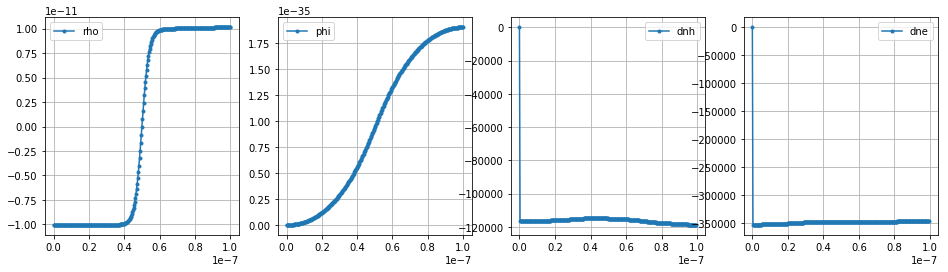

In [45]:
dx = mesh[1]-mesh[0]
dx_inv = 1/dx**2

_fac=1e10
_rho_tmp = get_rho(_n_h0, _n_e0, N_D, N_A)
_phi = get_phi(mesh, _rho_tmp, epsilon, q, debug=False, scale_fac=_fac)
_phi = _phi - _phi[0] #--> set the leftmost value to zero. 

dnh, _ah, _nh = get_dndt(mesh, _phi, _n_h0, D_h, G, U, qkt, True)
dne, _ae, _ne = get_dndt(mesh, _phi, _n_e0, D_e, G, U, -qkt, True)

ncols=4
fig, axes = plt.subplots(ncols=ncols, figsize=(ncols*4, 4))
label_data = OrderedDict([('rho',_rho_tmp), ('phi',_phi), ('dnh',dnh), ('dne', dne)])
for _ax, (_l, _d) in zip(axes, label_data.items()):
    print(_l, _d[:5], _d[-5:])
    _ax.plot(mesh, _d, '.-', label=_l)
    _ax.grid()
    _ax.legend()



/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:34: RuntimeWarning: invalid value encountered in double_scalars


iteration 0, trial 0,  phi is too large : 1.161138632285472e+268 > 1e+100
iteration 0, trial 1,  phi is too large : 5.810653789266508e+264 > 1e+100


/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in true_divide
/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in true_divide
/Users/nagoyan/anaconda/envs/p3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


iteration 0 finished.
iteration 1, trial 0, phi is np.nan : nan
iteration 1, trial 1, phi is np.nan : nan
iteration 1, trial 2, phi is np.nan : nan
iteration 1, trial 3, phi is np.nan : nan
iteration 1, trial 4, phi is np.nan : nan
iteration 1, trial 5, phi is np.nan : nan
iteration 1, trial 6, phi is np.nan : nan
get_phi diverged. use old phi
iteration 1 finished.
iteration 2, trial 0, phi is np.nan : nan
iteration 2, trial 1, phi is np.nan : nan
iteration 2, trial 2, phi is np.nan : nan
iteration 2, trial 3, phi is np.nan : nan
iteration 2, trial 4, phi is np.nan : nan
iteration 2, trial 5, phi is np.nan : nan
iteration 2, trial 6, phi is np.nan : nan
get_phi diverged. use old phi
iteration 2 finished.
iteration 3, trial 0, phi is np.nan : nan
iteration 3, trial 1, phi is np.nan : nan
iteration 3, trial 2, phi is np.nan : nan
iteration 3, trial 3, phi is np.nan : nan
iteration 3, trial 4, phi is np.nan : nan
iteration 3, trial 5, phi is np.nan : nan
iteration 3, trial 6, phi is np.na

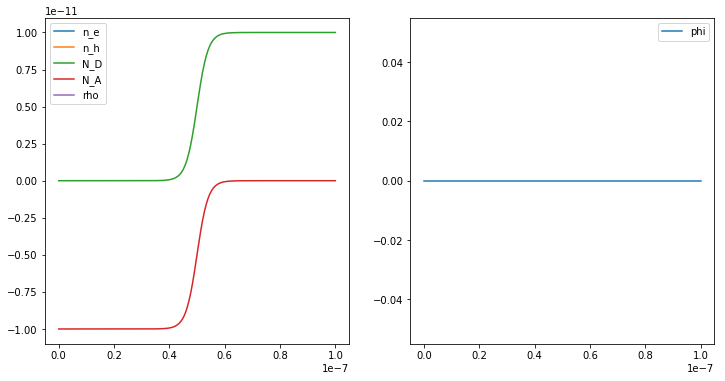

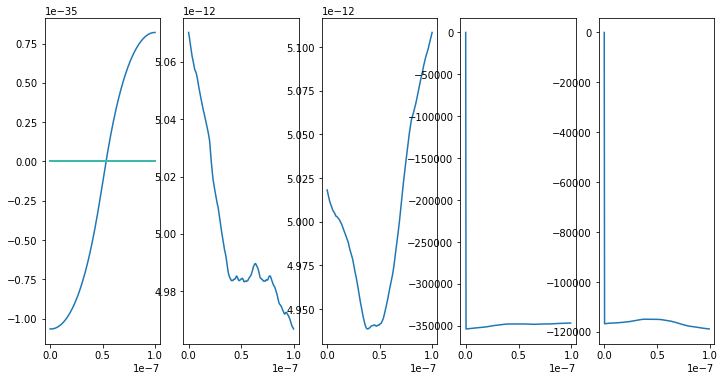

In [13]:
n_h = _n_h0
n_e = _n_e0
phi = phi0

dx = mesh[1]-mesh[0]
dx_inv = 1/dx

nmesh = len(mesh)
nit = 10

_rho = np.zeros([nit, nmesh])
_phi = np.zeros([nit, nmesh])
_n_e = np.zeros([nit, nmesh])
_n_h = np.zeros([nit, nmesh])
_dne = np.zeros([nit, nmesh])
_dnh = np.zeros([nit, nmesh])

dne = [np.inf]
dnh = [np.inf]

ne_tot = simps(N_D, mesh)/Lx
nh_tot = simps(N_A, mesh)/Lx

itmp = int(nit/10)
huge=1e100
scale_facs=[1e3, 1e6, 1e9, 1e12, 1e15, 1e18]
count_max = len(scale_facs) + 1
for i in range(nit):
    dne0 = np.sum(dne)
    dnh0 = np.sum(dnh)
    
    rho = get_rho(n_h, n_e, N_D, N_A)

    phi = get_phi(mesh, rho, epsilon, q, debug=False, scale_fac=True)

    _phi_max =  np.max(np.abs(phi))
    _count = 0
    while _count < count_max and (_phi_max > huge  or np.isnan(_phi_max)):
        if _phi_max > huge:
            print('iteration {}, trial {},  phi is too large : {} > {}'.format(i, _count, _phi_max, huge))
        else:
            print('iteration {}, trial {}, phi is np.nan : {}'.format(i, _count, _phi_max))

        if _count < len(scale_facs):
                _scale_fac = scale_facs[_count]
        else:
                _scale_fac = True
        phi = get_phi(mesh, rho, epsilon, q, debug=False, scale_fac=_scale_fac)
        _phi_max =  np.max(np.abs(phi))
        _count += 1

    if _count == count_max:
        print('get_phi diverged. use old phi')
        phi = _phi[-1]
        
    dnh = get_dndt(mesh, phi, n_h, D_h, G, U, qkt)
    dne = get_dndt(mesh, phi, n_e, D_e, G, U, -qkt)
    

    _dnmax = np.max(np.abs(np.concatenate([dne, dnh])))
    nmax = np.max(np.abs(np.concatenate([n_e, n_h])))*10


    if _dnmax > nmax:
        print('iteration {} dnmax is too large :{:.4e} > {:.4e}'.format(i, _dnmax, nmax), end=None)
        dnh = dnh / simps(dnh, mesh)*simps(n_h, mesh)*100
        dne = dne / simps(dne, mesh)*simps(n_e, mesh)*100
        _dnmax = np.max(np.abs(np.concatenate([dne, dnh])))
        nmax = np.max(np.abs(np.concatenate([n_e, n_h])))                    
        print('new dnmax', _dnmax)
        
    _rho[i] = rho
    _phi[i] = phi
    _n_e[i] = n_e
    _n_h[i] = n_h
    _dne[i] = dne
    _dnh[i] = dnh
       
    n_e = n_e + dne 
    n_h = n_h + dnh
    n_e = n_e / (simps(n_e, mesh)/Lx) * ne_tot
    n_h = n_h / (simps(n_h, mesh)/Lx) * nh_tot

    if i % itmp==0:
        print('iteration {:d} finished.'.format(i))
        
fig, axes = plt.subplots(ncols=2, figsize=(12, 6))
ax0, ax1 = axes
ax0.plot(mesh, -n_e, label='n_e')
ax0.plot(mesh, n_h, label='n_h')
ax0.plot(mesh, N_D, label='N_D')
ax0.plot(mesh, -N_A, label='N_A')
ax0.plot(mesh, rho, label='rho')
ax0.legend()
ax1.plot(mesh, phi, label='phi')
ax1.legend()

dd = 1
fig, axes = plt.subplots(ncols=5, figsize=(12,6))
for _a, _d in zip(axes, [_phi, _n_e, _n_h, _dne, _dnh]):
    _a.plot(mesh, _d[::dd, :].T)

In [14]:
_phi[0]

array([-1.06553919e-35, -1.06564300e-35, -1.06568218e-35, -1.06565668e-35,
       -1.06556647e-35, -1.06541149e-35, -1.06519166e-35, -1.06490690e-35,
       -1.06455713e-35, -1.06414225e-35, -1.06366215e-35, -1.06311670e-35,
       -1.06250577e-35, -1.06182921e-35, -1.06108686e-35, -1.06027855e-35,
       -1.05940410e-35, -1.05846332e-35, -1.05745600e-35, -1.05638193e-35,
       -1.05524090e-35, -1.05403264e-35, -1.05275693e-35, -1.05141349e-35,
       -1.05000206e-35, -1.04852235e-35, -1.04697407e-35, -1.04535693e-35,
       -1.04367063e-35, -1.04191485e-35, -1.04008925e-35, -1.03819350e-35,
       -1.03622724e-35, -1.03419011e-35, -1.03208174e-35, -1.02990174e-35,
       -1.02764971e-35, -1.02532525e-35, -1.02292792e-35, -1.02045731e-35,
       -1.01791296e-35, -1.01529444e-35, -1.01260128e-35, -1.00983300e-35,
       -1.00698911e-35, -1.00406912e-35, -1.00107252e-35, -9.97998790e-36,
       -9.94847406e-36, -9.91617828e-36, -9.88309508e-36, -9.84921893e-36,
       -9.81454416e-36, -

In [15]:
x=_phi[-1,-1]

In [16]:
x

0.0

In [17]:
bool(x)

False

In [18]:
np.isnan(x)

False